In [1]:
import os
os.chdir('/home/soham/Desktop/GitHub/BTP/')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.inspection import DecisionBoundaryDisplay
from mpl_toolkits.mplot3d import Axes3D


combined_data = pd.read_csv('data/labelled/labelled.csv')
combined_data.head(5)

,CFU/mL,Sensor2,Sensor1,Sensor3,label
0,30500000.0,70.734,-68.02,52.47,1
1,3050000.0,50.162,-95.70,32.63,1
2,305000.0,-8.390,-99.96,-10.41,1
3,30500.0,-18.700,-107.42,-23.93,1
4,3050.0,-19.620,-109.94,-27.24,1


## Random Forest with Grid Search CV (No PCA)

In [2]:
X = combined_data[['Sensor1', 'Sensor2', 'Sensor3']]
y = combined_data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [3]:
param_grid = {
    'n_estimators': [10, 25, 50, 75, 100, 125, 150],
    'max_depth': [None, 5, 10, 15, 20, 25, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}


rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=0)

grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Test set accuracy: {accuracy:.4f}")

Best parameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
Best cross-validation score: 0.9618


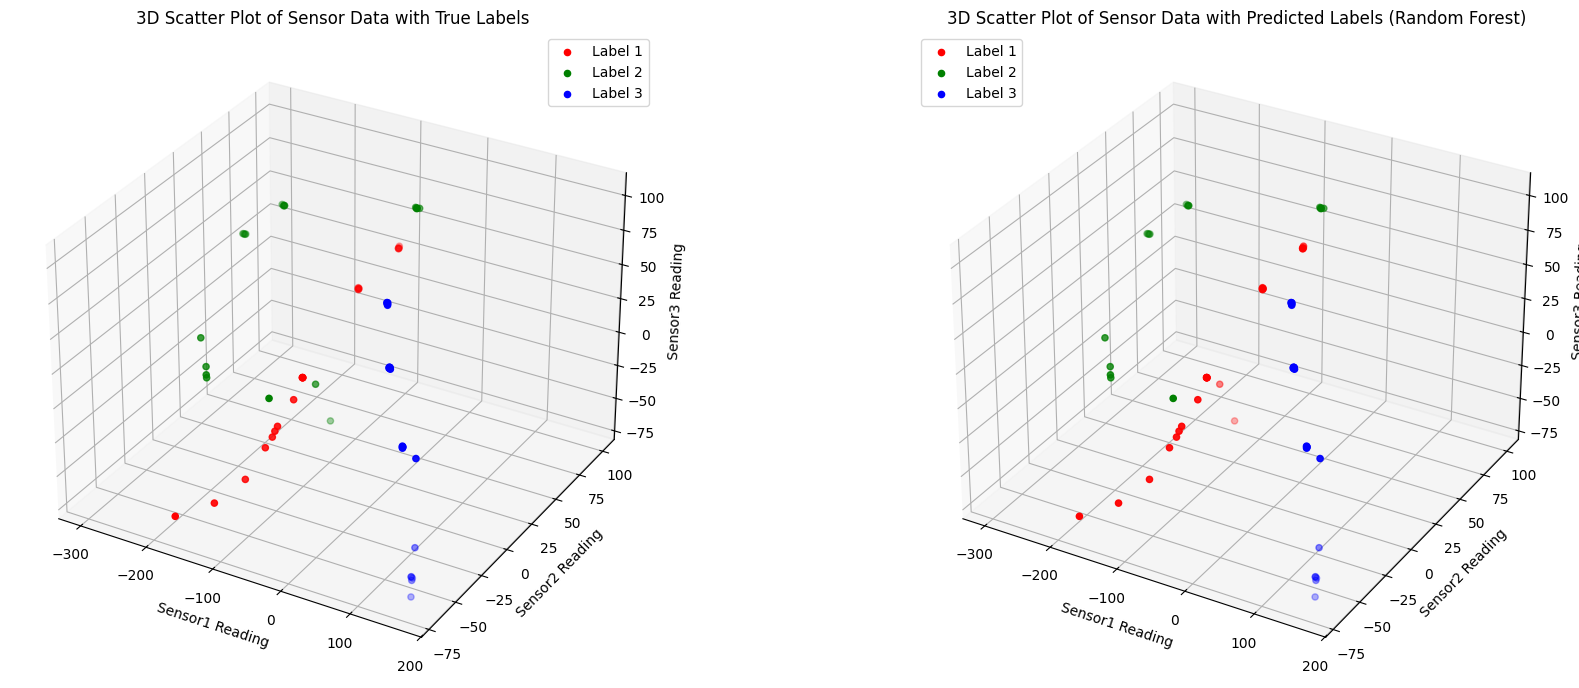

In [5]:
fig = plt.figure(figsize=(20, 15))
axs = [fig.add_subplot(121, projection='3d'), fig.add_subplot(122, projection='3d')]

all_predicted_labels = best_rf.predict(X)
combined_data['Predicted_Label'] = all_predicted_labels
colors = ['r', 'g', 'b']  

# PLOTTING TRUE LABELS

for label in combined_data['label'].unique():
    subset = combined_data[combined_data['label'] == label]
    axs[0].scatter(subset['Sensor1'], subset['Sensor2'], subset['Sensor3'], label=f'Label {label}', c=colors[label-1])

axs[0].set_xlabel('Sensor1 Reading')
axs[0].set_ylabel('Sensor2 Reading')
axs[0].set_zlabel('Sensor3 Reading')
axs[0].set_title('3D Scatter Plot of Sensor Data with True Labels')
axs[0].legend(loc='upper right')


# PLOTTING PREDICTED LABELS

for label in combined_data['Predicted_Label'].unique():
    subset = combined_data[combined_data['Predicted_Label'] == label]
    axs[1].scatter(subset['Sensor1'], subset['Sensor2'], subset['Sensor3'], label=f'Label {label}', c=colors[label-1])

axs[1].set_xlabel('Sensor1 Reading')
axs[1].set_ylabel('Sensor2 Reading')
axs[1].set_zlabel('Sensor3 Reading')
axs[1].set_title('3D Scatter Plot of Sensor Data with Predicted Labels (Random Forest)')
axs[1].legend(loc='upper left')


plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

## Random Forest (RF) with PCA

In [6]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)  

x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

In [7]:
rf_classifier_pca = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier_pca.fit(X_pca, y)

print(f"PCA Random Forest Accuracy: {rf_classifier_pca.score(X_pca, y):.4f}")

PCA Random Forest Accuracy: 1.0000


<Figure size 1500x1000 with 0 Axes>

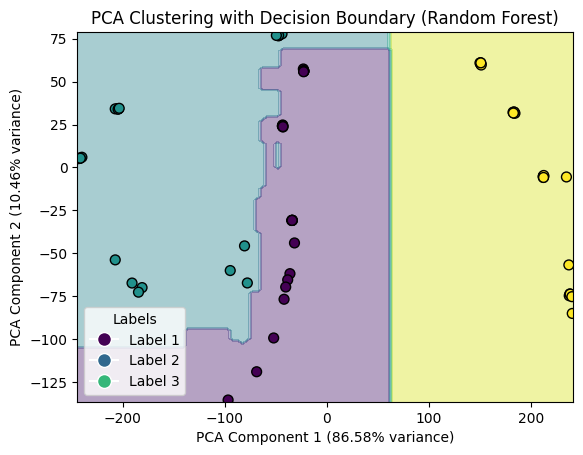

In [8]:
Z = rf_classifier_pca.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(15, 10))
DecisionBoundaryDisplay.from_estimator(rf_classifier_pca, X_pca, grid_resolution=100, cmap='viridis', alpha=0.4)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', edgecolor='k', s=50)
plt.title('PCA Clustering with Decision Boundary (Random Forest)')
plt.xlabel(f'PCA Component 1 ({pca.explained_variance_ratio_[0] * 100:.2f}% variance)')
plt.ylabel(f'PCA Component 2 ({pca.explained_variance_ratio_[1] * 100:.2f}% variance)')

handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.viridis(i / 3), markersize=10, label=f'Label {i+1}') for i in range(3)]
plt.legend(handles=handles, title='Labels')

plt.show()

## RF-PCA with noise

Noise level = 0.05
Training accuracy = 1.0
Test accuracy = 1.0


<Figure size 1000x800 with 0 Axes>

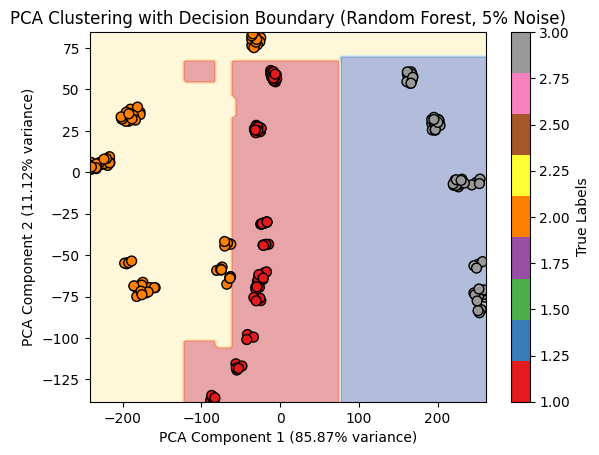

Noise level = 0.1
Training accuracy = 1.0
Test accuracy = 0.9428571428571428


<Figure size 1000x800 with 0 Axes>

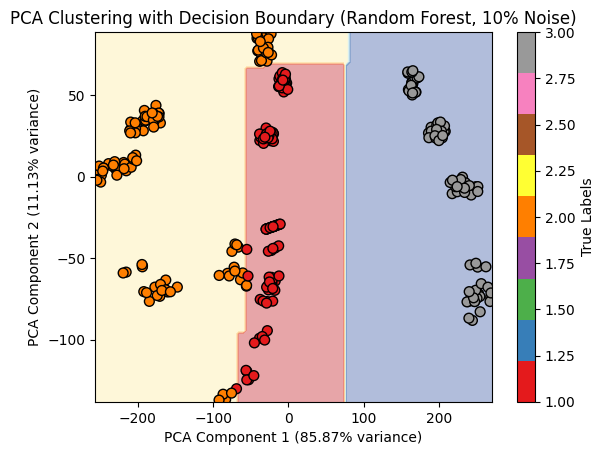

Noise level = 0.15
Training accuracy = 1.0
Test accuracy = 0.9714285714285714


<Figure size 1000x800 with 0 Axes>

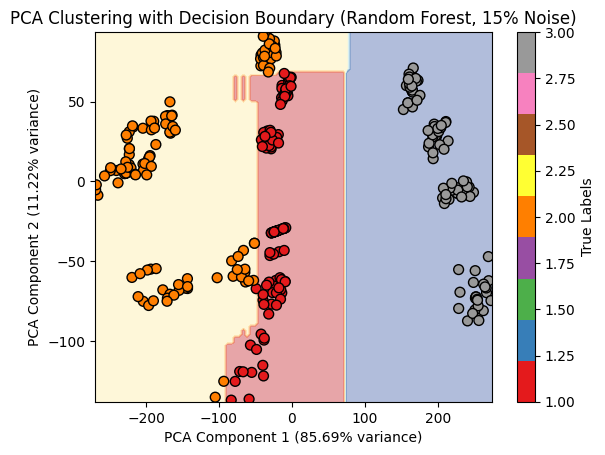

Noise level = 0.2
Training accuracy = 1.0
Test accuracy = 0.9714285714285714


<Figure size 1000x800 with 0 Axes>

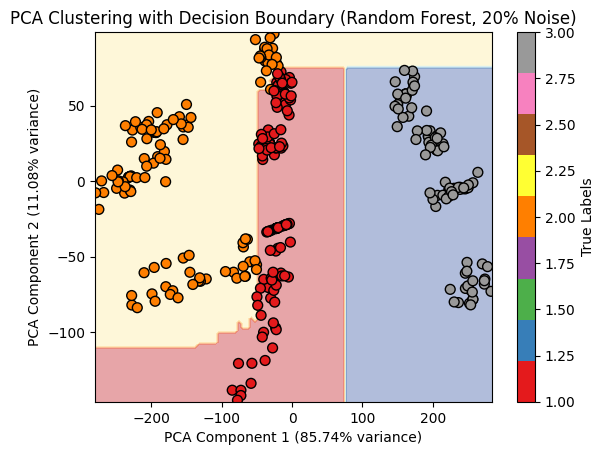

Noise level = 0.25
Training accuracy = 1.0
Test accuracy = 0.9619047619047619


<Figure size 1000x800 with 0 Axes>

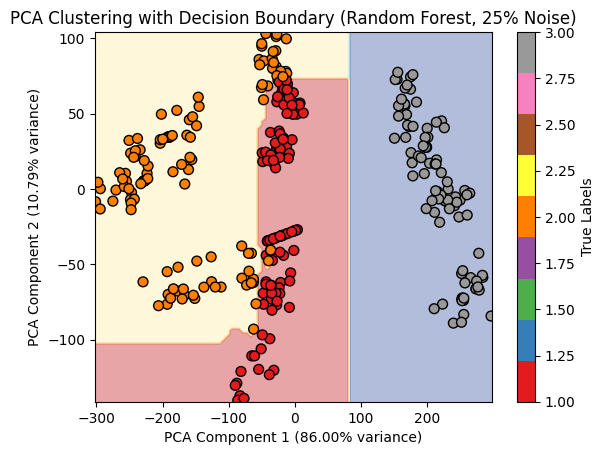

Noise level = 0.3
Training accuracy = 1.0
Test accuracy = 0.9523809523809523


<Figure size 1000x800 with 0 Axes>

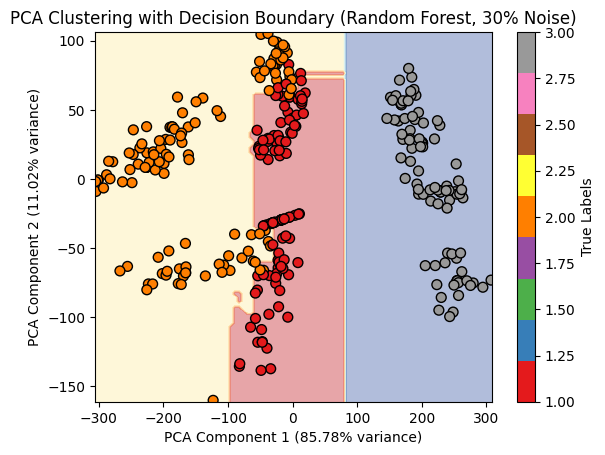

In [16]:
def add_noise(data, labels, noise_level, target_size=350):
    combined_data = data.copy()
    combined_labels = labels.copy()

    while len(combined_data) < target_size:
        noisy_data = data.copy()
        new_data_points = []

        for sensor in ['Sensor1', 'Sensor2', 'Sensor3']:
            noise = np.random.uniform(-noise_level, noise_level, size=noisy_data.shape[0])
            new_data = noisy_data[sensor] + (noisy_data[sensor] * noise)
            new_data_points.append(new_data)

        new_data_df = pd.DataFrame({
            'Sensor1': new_data_points[0],
            'Sensor2': new_data_points[1],
            'Sensor3': new_data_points[2]
        })
        new_labels = labels.copy()

        combined_data = pd.concat([combined_data, new_data_df], ignore_index=True)
        combined_labels = pd.concat([combined_labels, new_labels], ignore_index=True)

    combined_data = combined_data.iloc[:target_size]
    combined_labels = combined_labels.iloc[:target_size]

    return combined_data, combined_labels



def apply_rf_pca_and_plot(noise_level):

    # Adding noise to the data

    noisy_data, noisy_labels = add_noise(combined_data[['Sensor1','Sensor2','Sensor3']], combined_data['label'], noise_level)
    X_pca = pca.fit_transform(noisy_data)  

    # Split into training and testing data

    X_train, X_test, y_train, y_test = train_test_split(X_pca, noisy_labels, test_size=0.3, random_state=42)

    # Random Forest

    rf_classifier_pca = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_classifier_pca.fit(X_train, y_train)  
    
    train_pred = rf_classifier_pca.predict(X_train)
    print('Training accuracy =',accuracy_score(y_train, train_pred))

    y_pred = rf_classifier_pca.predict(X_test)
    print('Test accuracy =',accuracy_score(y_test, y_pred))


    # Plotting
    all_predicted_labels = rf_classifier_pca.predict(X_pca)

    x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
    y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

    Z = rf_classifier_pca.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(10, 8))
    DecisionBoundaryDisplay.from_estimator(rf_classifier_pca, X_pca, grid_resolution=100, cmap=plt.cm.RdYlBu, alpha=0.4)

    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=all_predicted_labels, cmap=plt.cm.Set1, edgecolor='k', s=50)
    plt.title(f'PCA Clustering with Decision Boundary (Random Forest, {noise_level*100:.0f}% Noise)')
    plt.xlabel(f'PCA Component 1 ({pca.explained_variance_ratio_[0] * 100:.2f}% variance)')
    plt.ylabel(f'PCA Component 2 ({pca.explained_variance_ratio_[1] * 100:.2f}% variance)')
    plt.colorbar(label='True Labels')
    plt.legend()
    plt.show()



noise_levels = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30]
for noise in noise_levels:
    print("Noise level =", noise)
    apply_rf_pca_and_plot(noise)